In [19]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,PillowWriter,HTMLWriter
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

case_name='case02'

In [5]:
def actual_f(x):
    return 0.1*((x-59)**3)+2

def regr_sided(X,Y,t,k,b):
    # Dispose points outside bandwidth
    YL=Y[np.logical_and(t-b<X,X<t)]
    XL=X[np.logical_and(t-b<X,X<t)]
    
    # Calculate weights
    get_weight=np.vectorize(lambda x:k((np.abs((x-t)))/b))
    WL=get_weight(XL)

    # Reshape for lib use
    # Every data has a single feature
    XL=XL.reshape(-1,1)
    YL=YL.reshape(-1,1)
    
    # Create linear regression object
    regrL = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regrL.fit(XL, YL, sample_weight=WL)
    
    return regrL


def bias(X,Y,t,k,i):
    final_regr=regr_sided(X,Y,t,k,i)
    true_err=(final_regr.predict([[t]])[0][0]-actual_f(t))**2
    return true_err

In [6]:
def get_data():
    n1=60
    n2=0.2
    m=18
    X=np.random.rand(n1)*10-5+59 #can change the distribution of X
    for i in range(1,m):
        A=59-0.1*i-np.random.rand(int(n2*(m-i)))*0.1*(m-i)
        X=np.hstack((X,A))
    for j in range(1,m):
        B=59-0.1*m-np.random.rand(int(n2*(m-j)))*0.1*(m-j)
        X=np.hstack((X,B))
    Y=np.vectorize(actual_f)(X)
    for k in range(3):
        Y=Y+0.6*np.random.rand(np.size(X))
    Y=Y-0.9
    Y=Y[np.logical_and(59-2.8**1.5<X,X<59)]
    X=X[np.logical_and(59-2.8**1.5<X,X<59)]
    return (X,Y)

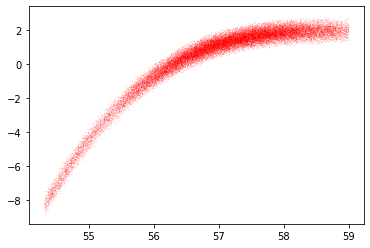

In [7]:
testset=[]
for i in range(500):
    v=get_data()
    testset.append(v)
    X,Y=v
    plt.scatter(X,Y,s=0.001,color='red')
plt.show()

In [8]:
def repeat_test(t,k,b):
    errsum=0
    cnt=0
    for (X,Y) in testset:
        errsum+=bias(X,Y,t,k,b)
        cnt+=1
    return errsum/cnt

In [12]:
def bezier(p,t):
    # See https://javascript.info/bezier-curve
    if len(p)==1:
        return p[0]
    p2=[]
    for i in range(len(p)-1):
        p2.append((1-t)*p[i]+t*p[i+1])
    return bezier(p2,t)

In [13]:
def gen_param():
    p=np.array([1,np.random.rand(1)[0],np.random.rand(1)[0],0])
    return [lambda x:bezier(p,x),p]

In [14]:
t=59
ker_cnt=200
band_steps=50
kb=np.zeros((ker_cnt,band_steps))
param_set=[]
for i in range(ker_cnt):
    g=gen_param()
    param_set.append(g)
    print('Running param set ',i,g[1][1:3])
    k=0
    for j in np.exp(np.linspace(-0.3,1.2,band_steps)):
        b=repeat_test(t,g[0],j)
        kb[i][k]=b
        k=k+1

Running param set  0 [0.28997531 0.91714125]
Running param set  1 [0.15287664 0.8418404 ]
Running param set  2 [0.70119815 0.70501919]
Running param set  3 [0.46945018 0.57829407]
Running param set  4 [0.19242096 0.4171195 ]
Running param set  5 [0.24796584 0.49881609]
Running param set  6 [0.88033462 0.93954191]
Running param set  7 [0.81694229 0.72184011]
Running param set  8 [0.91267643 0.26212375]
Running param set  9 [0.17396539 0.8761733 ]
Running param set  10 [0.57211525 0.04906107]
Running param set  11 [0.93817084 0.27581835]
Running param set  12 [0.48738153 0.14612389]
Running param set  13 [0.93610707 0.02663943]
Running param set  14 [0.2778202  0.60522165]
Running param set  15 [0.94973858 0.99483882]
Running param set  16 [0.01096205 0.32928207]
Running param set  17 [0.83890753 0.06107527]
Running param set  18 [0.57228548 0.20818723]
Running param set  19 [0.645287   0.72352336]
Running param set  20 [0.71279162 0.29885156]
Running param set  21 [0.77680452 0.05669191

In [15]:
f = open (r'outputbkt2.txt','w')
for param in param_set:
    print(i,param[1][1],param[1][2],file=f)
kerr=np.zeros(band_steps)+100
kbest=np.zeros(band_steps).astype(int)
for j in range(band_steps):
    for i in range(ker_cnt):
        if kerr[j]>kb[i][j]:
            kerr[j]=kb[i][j]
            kbest[j]=i
    print(kerr[j],kbest[j],file=f)

f.close()

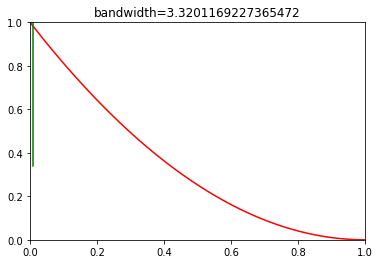

In [20]:
fig, ax = plt.subplots()
curve, = plt.plot([],[],color='red')
line1, = plt.plot([],[],color='green')
line2, = plt.plot([],[],color='green')

def init():
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    return
band_set=np.exp(np.linspace(-0.3,1.2,band_steps))
def animate(j):
    ax.set_title('bandwidth='+str(band_set[j]))
    ker=param_set[kbest[j]][0]
    p=param_set[kbest[j]][1]
    X=np.linspace(0,1,100)
    curve.set_data(X,np.vectorize(ker)(X))
    line1.set_data([0.01,0.01],[p[0],p[1]])
    line2.set_data([0.99,0.99],[p[2],p[3]])
    return curve,line1,line2

ani = FuncAnimation(fig=fig, func=animate, frames=band_steps, init_func=init, interval=30, blit=False)
writer = PillowWriter()
ani.save(case_name+"_graph.gif", writer=writer)
hwriter = HTMLWriter(fps=5)
ani.save(case_name+'_graph.html',writer=hwriter)